Number of Price changes greater than or equal to 1σ = 145


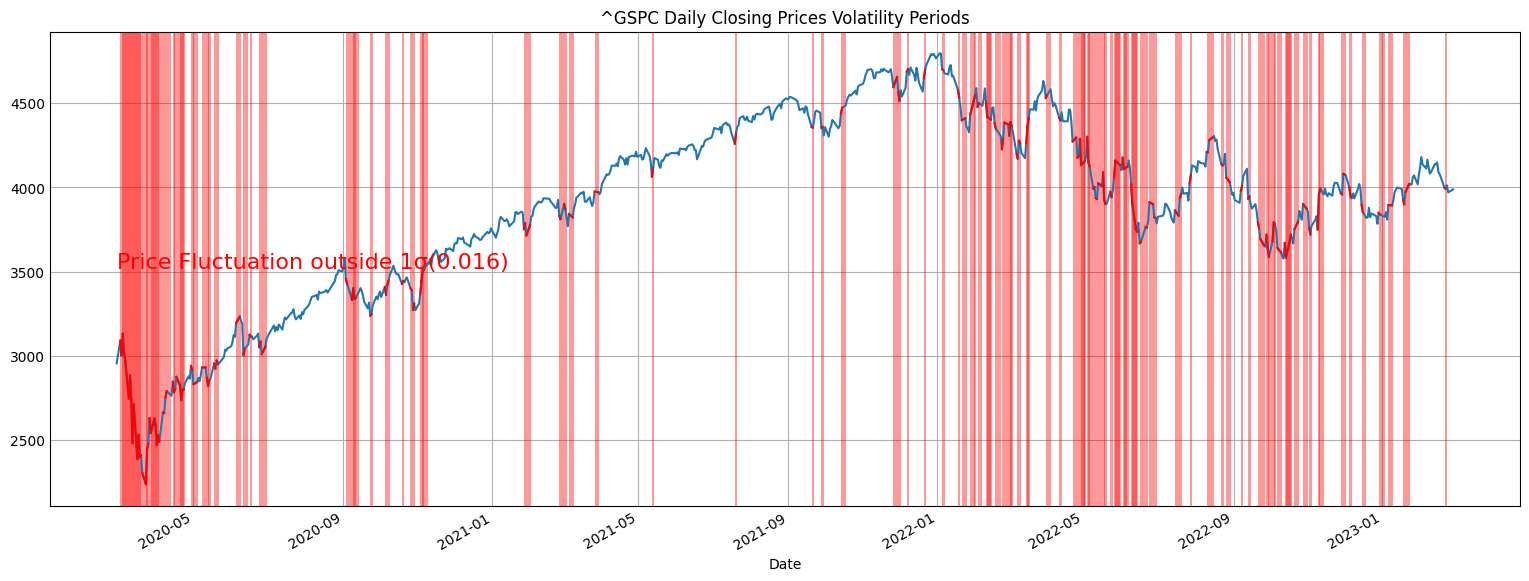

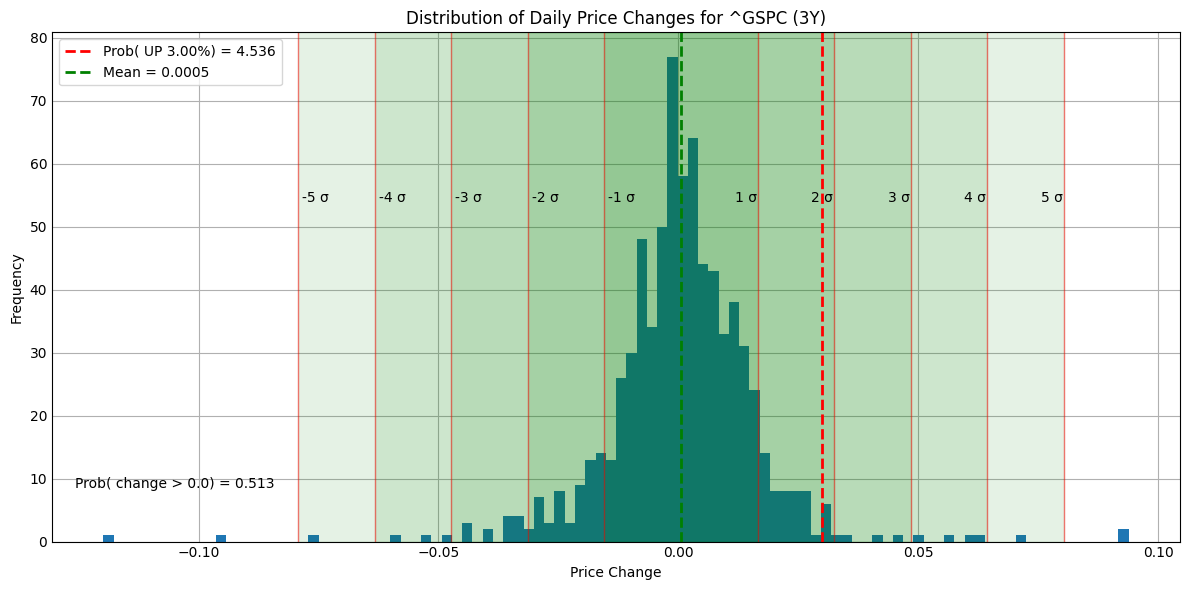

Stats:
                                0
Data Points Count             755
Look Back Period               3Y
1 σ (%)                       1.6
Average Daily Price Change   0.05
Max Price Rise (%)           9.38
Max Price Drop (%)         -11.98
Price Changes>1Sigma Count    145


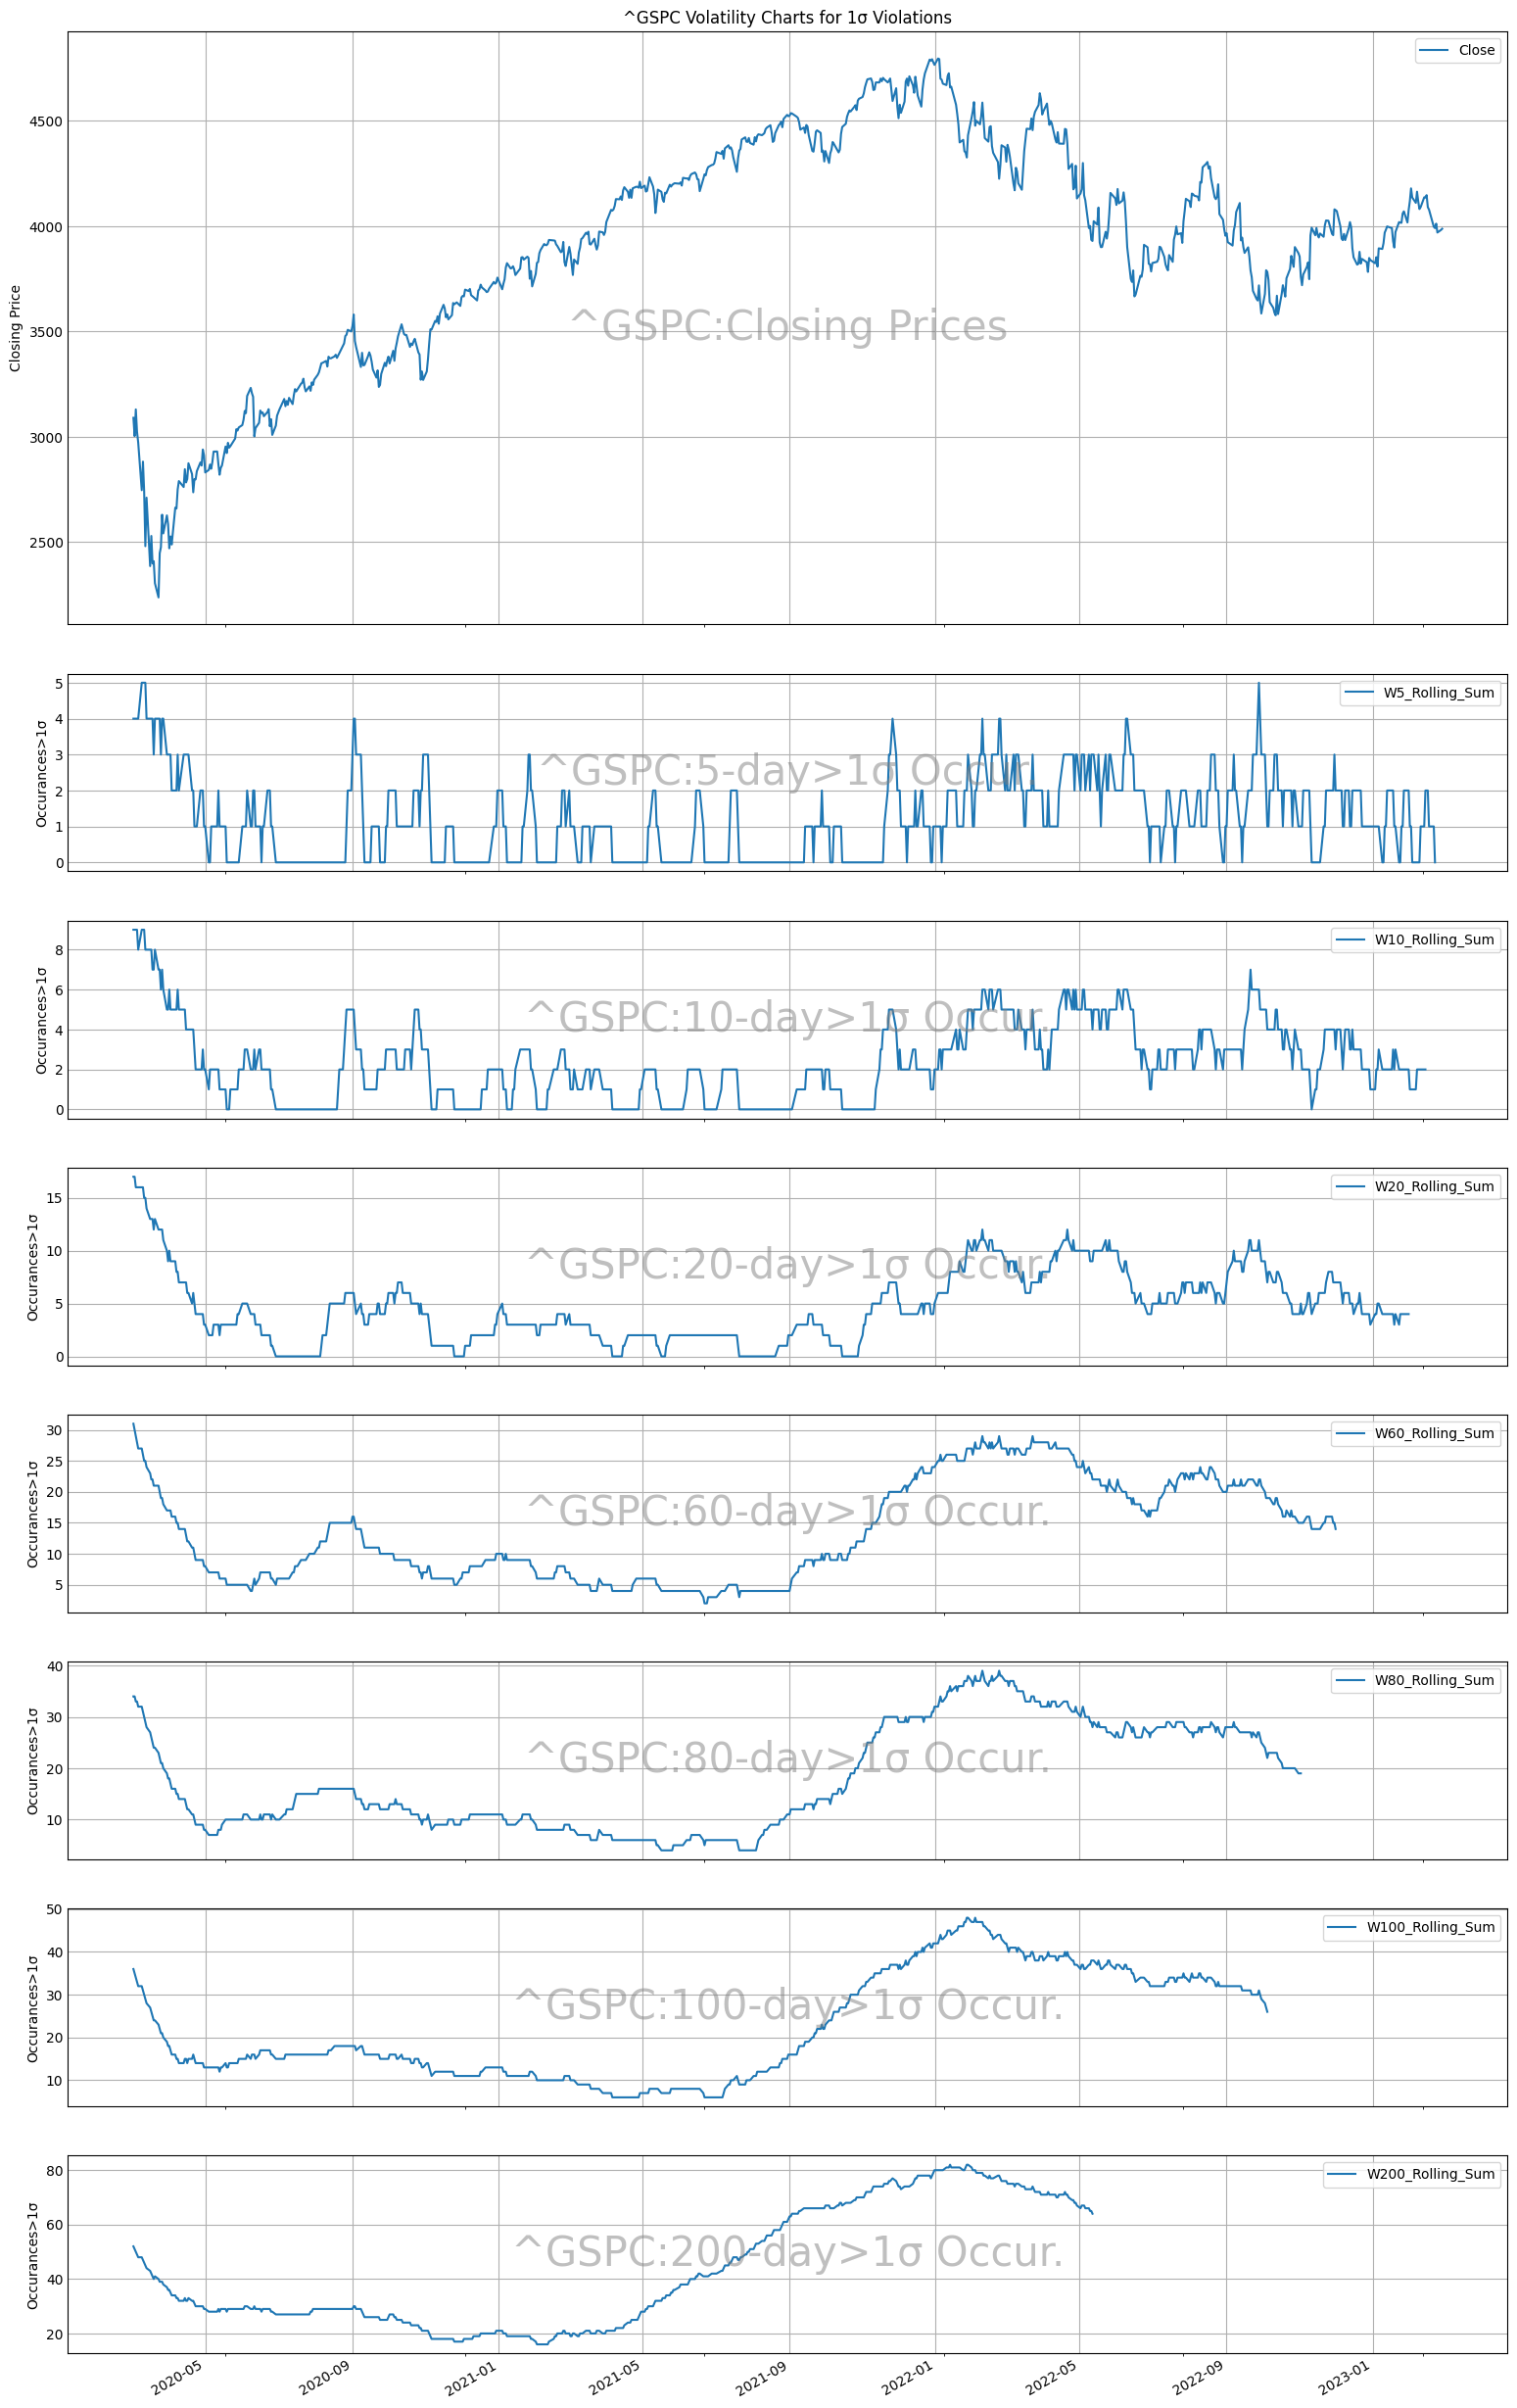

5-days Window Price Changes above 1σ 
 count    751.000000
mean       1.205060
std        1.153788
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: W5_Rolling_Sum, dtype: float64
10-days Window Price Changes above 1σ 
 count    746.000000
mean       2.391421
std        1.966056
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max        9.000000
Name: W10_Rolling_Sum, dtype: float64
20-days Window Price Changes above 1σ 
 count    736.000000
mean       4.707880
std        3.411105
min        0.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       17.000000
Name: W20_Rolling_Sum, dtype: float64
60-days Window Price Changes above 1σ 
 count    696.000000
mean      13.550287
std        8.039492
min        2.000000
25%        6.000000
50%       11.000000
75%       21.000000
max       31.000000
Name: W60_Rolling_Sum, dtype: float64
80-days Window Price Changes above 1σ 
 count    6

In [13]:
""" 
Code by Al Sabawi 2023-02-19

Interactively examine the volatility of a stock price 

"""
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd
import datetime
from math import isnan
plt.style.use('_mpl-gallery')

def get_window_dates(window):
    start_date = window.index[0]
    end_date = window.index[-1]
    # return start_date, end_date
    return start_date.timestamp()

def vol_windows(df_in,stock,window_sizes, std_mult, period):
    prices = df_in.values

    hv = np.abs(prices[1:] - prices[:-1]) > std_mult*np.std(prices[1:] - prices[:-1])

    # Convert to pandas DataFrame
    df = pd.DataFrame({'Close': prices[1:], 'hv': hv},index=df_in.index[1:])
    
    # Compute rolling sum of high volatility occurrences for each window size
    rolling_sums_list = [[] for x in range(len(window_sizes))]
    roll_sums_dates = []
    roll_sums_window = []
    roll_sums_df_list = {}
    w_pos = 0
    
    for w in window_sizes:
        # Get the rolling window series and sum it
        rolling = df['hv'].rolling(window=w, min_periods=w)
        rolling_sum = rolling.sum()
        
        # Build a rolling sums list for each window interval
        rolling_sums_list[w_pos].append(rolling_sum)
        window_dates = rolling.apply(get_window_dates, raw=False) 
        
        # Get the timestamps of the start of each window in the original dataframe index
        timestamp_list = [datetime.datetime.fromtimestamp(x) if not isnan(x) else float('nan') for x in window_dates]

        # Create a list of Dataframes for each window list for plotting and comparison later 
        roll_sums_df_list[f'W{w}'] =pd.DataFrame({f'W{w}_Rolling_Sum':rolling_sums_list[w_pos][0],
                                                  'Start_Date':timestamp_list}).dropna()
        roll_sums_df_list[f'W{w}'].reset_index('Date',inplace=True, drop=True)
        roll_sums_df_list[f'W{w}'].set_index('Start_Date', inplace=True)
        roll_sums_df_list[f'W{w}'].tz_localize(None)
        roll_sums_df_list[f'W{w}'] = roll_sums_df_list[f'W{w}'].tz_localize('America/New_York')
        
        # Create a list of non-zero list in case we need it later
        for x in rolling_sums_list[w_pos]:
            above_zero_vol = []
            for y in x.values:
                if y > 0:
                    above_zero_vol.append(y)
            # print(above_zero_vol)
                
        w_pos +=1

    height_ratios=[3]
    for i in range(len(window_sizes)): 
        height_ratios.append(1)
    # print(f"height_ratios = {height_ratios}")
    
    fig, axes = plt.subplots(len(window_sizes)+1, 1,
                             figsize=(15,30), 
                             height_ratios=height_ratios,
                             sharex=True,
                            )
    
    df['Close'].plot(ax=axes[0])
    axes[0].set_title(f"{stock} Volatility Charts for {std_mult}\u03C3 Violations")
    axes[0].grid(True)
    axes[0].text(0.5, 0.5, f'{stock}:Closing Prices', transform=axes[0].transAxes,
            fontsize=30, color='gray', alpha=0.5,
            ha='center', va='center', rotation=0)
    axes[0].legend()
    axes[0].set_xlabel('Dates')
    axes[0].set_ylabel('Closing Price')
    
    # plt.show()
    ax_inc = 1
    for w in window_sizes:
        df = df.merge(roll_sums_df_list[f'W{w}'][f'W{w}_Rolling_Sum'], left_index=True, right_index=True, how='outer')
        
        df[f'W{w}_Rolling_Sum'].plot(ax=axes[ax_inc])
        axes[ax_inc].set_ylabel(f'Occurances>{std_mult}\u03C3')
        axes[ax_inc].legend()
        axes[ax_inc].grid(True)
        axes[ax_inc].text(0.5, 0.5, f'{stock}:{w}-day>{std_mult}\u03C3 Occur.', transform=axes[ax_inc].transAxes,
                fontsize=30, color='gray', alpha=0.5,
                ha='center', va='center', rotation=0)
        
        
        ax_inc +=1
        
    plt.show()
    for w in window_sizes:
        print(f"{w}-days Window Price Changes above {std_mult}\u03C3 \n",df[f'W{w}_Rolling_Sum'].describe())
        


def plot_price_changes(ticker, period, num_bins, price_change,sig_threshhold):
    # Load stock data
    ticker = ticker.upper()
    stock = yf.Ticker(ticker)
    data = stock.history(period=period)
    period_str = str(period).upper()
    
    # Calculate daily price changes
    data["price_change"] = data["Close"].pct_change()

    mu, std = norm.fit(data["price_change"].dropna())
    
    ax = data["Close"].plot(figsize=(15,6),grid=True,title=f"{ticker} Daily Closing Prices Volatility Periods")
    # sig_threshhold = sigma_threshhold 
    
    ax.text(data.index.min(), 0.5*(data['Close'].max()-data['Close'].min())+data['Close'].min(), 
            f"Price Fluctuation outside {sig_threshhold}\u03C3({(sig_threshhold*std):0.3f})",color='r',fontsize=16)
    
    vol_changes = pd.DataFrame(columns=[str(sig_threshhold)+"sigma","Date"])
    for i in range(len(data)-1):
        # if data["price_change"][i+1] > (mu + (sig_threshhold*std)) or \
        # data["price_change"][i+1] < (mu - (sig_threshhold*std)):
        if data["price_change"][i] > (mu + (sig_threshhold*std)) or \
        data["price_change"][i] < (mu - (sig_threshhold*std)):
            ax.plot(data.index[i:i+2], data['Close'][i:i+2], color='r')
            if i+1 < len(data)+1:
                ax.axvspan(data.index[i], data.index[i+2], alpha=0.4, facecolor='r',lw=3)
            dic = {  str(sig_threshhold)+"sigma" : [data["price_change"][i]], 
                   "Date": [data.index[i]] }
            vol_changes = pd.concat([vol_changes,pd.DataFrame(dic)])
        
    vol_changes.set_index('Date',inplace=True)
    print(f'Number of Price changes greater than or equal to {str(sig_threshhold)}\u03C3 =', 
          len(vol_changes) )
    
    # Plot distribution of price changes
    plt.subplots(figsize=(12,6))
    yh, xh, _ = plt.hist(data["price_change"].dropna(), bins=num_bins)
    xh_max = xh.max()
    yh_max = yh.max()
    plt.title(f"Distribution of Daily Price Changes for {ticker} ({period_str})")
    plt.xlabel("Price Change")
    plt.ylabel("Frequency")

    # Calculate probability of price change
    x = price_change
    if price_change>0.0:
        updown = 'UP'
    else:
        updown = 'DOWN'
        
    
    y = norm.pdf(x, mu, std)
    prob_above_zero = 1 - norm.cdf(0, mu, std)
    plt.axvline(x=x, color='r', linestyle='--', 
                label=f"Prob( {updown} {np.abs(price_change)*100:.2f}%) = {y:.3f}",lw=2)
    plt.axvline(x=mu, color='g', linestyle='--', label=f"Mean = {mu:.4f}",lw=2)
    plt.text(s=f'Prob( change > 0.0) = {prob_above_zero*100:0.3f}%',x=.02, y=0.10, 
             ha='left', va='bottom',transform=plt.gca().transAxes)
    
    for i in range(1, 6):
        sigma_min = mu - i * std
        sigma_max = mu + i * std
        plt.axvline(mu + i*std, color='r', alpha=0.5, linewidth=1)
        plt.axvline(mu - i*std, color='r', alpha=0.5, linewidth=1)
        plt.axvspan(mu - i*std, mu + i*std, alpha=0.1, color='g')
        plt.text(sigma_min + 0.05 * std, yh_max*0.7, f"{-i} \u03C3")
        plt.text(sigma_max - 0.3 * std, yh_max*0.7, f"{i} \u03C3")

            
    plt.grid(True)
    plt.tight_layout()
    plt.legend()

    plt.show()
    
    print("Stats:")
    stat_df = pd.DataFrame([[round(data["price_change"].count(),0),
                             period_str.upper(),
                            round(data['price_change'].std()*100,2),
                            round(data['price_change'].mean()*100,2),
                            round(data['price_change'].max()*100,2),
                            round(data['price_change'].min()*100,2),
                            round(len(vol_changes),0)]],
                           columns=["Data Points Count",
                                    "Look Back Period",
                                    '1 \u03C3 (%)',
                                    "Average Daily Price Change",
                                    'Max Price Rise (%)','Max Price Drop (%)',
                                    'Price Changes>'+str(sig_threshhold)+'Sigma Count'])
    print(stat_df.T)
    
    # Define rolling window sizes
    window_sizes = [5,10,20,60,80,100,200]

    # Call vol_windows() to compute and plot sigma violations in different time windows
    vol_windows(data['Close'],stock=ticker,window_sizes=window_sizes, std_mult=sig_threshhold, period=period)
    
# ----------------------------------------------------------------
if __name__ == "__main__":
    # User inputs :
    ticker = input("Enter Stock Symbol :")
    years_back = input("Enter how many prior years of prices to analyze (1-10):")
    price_change = input("Enter Price Change Percentage (%) to find the Probability of")
    sig_threshhold = input("Enter the Multiples of Std Dev. to Analyze for:")
    plot_price_changes(ticker=ticker,
                       period=str(years_back)+'y',
                       num_bins=100,
                       price_change=float(price_change)/100.0,
                       sig_threshhold = int(sig_threshhold))
